

---
> If you need help getting started with Google Colab or Jupyter Notebook, check [here](https://colab.research.google.com/drive/1PFuMbeS9eFvYkDK3ple7ooxdEkhWVqS5?usp=sharing).
---
**This is an VIEW ONLY notebook. Duplicate this notebook to follow along interactively.**




## Introduction
In this TargetSmart API tutorial project, we follow a mock Women's Advocacy Group (WAG) as they:

1. append data to their existing lists using **SmartMatch**,
2. compare demographic counts of their data with the national voter file using **ListBuilder**
3. upload their list to Facebook for digital advertising with **Onboarding**

So far, WAG has:

Completed *1. append data to a list using the SmartMatch API.* See the [documentation](docs.targetsmart.com) for that. 

## 2: Compare Demographic Counts of WAG Date with National Voter File

Step 2 will be split up into a few parts:

**A.** Gather demograhpic data from WAG's SmartMatch enhanced list.

**B.** Query the Listbuilder API to get national counts for the same demographics

**C.** Compare demograhpics from WAG's list and the National Voter File. 

## Let's get to the code!

### Importing Python Libraries

To analyze and plot our data, we'll be using powerful Python libraries like [Pandas](https://pandas.pydata.org/) and [Matplotlib](https://matplotlib.org/).

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import traceback
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick


### Creating a PDF file
To save the graphs we will be making later into a PDF, first create a variable PDF. 

If you want to save the PDF as images, one option is to use [pdf2image](https://pypi.org/project/pdf2image/) then using [PIL Image's](https://pillow.readthedocs.io/en/stable/reference/Image.html) `save()` function. Jupyter Notebook lets you save individual graphs by right clicking on the graph and click `Save image as..`.

In [13]:
pdf=PdfPages('WAG_and_National_graphs.pdf')

### Import the enhanced data file
Read the comma-separated values (CSV) file into a DataFrame. DataFrame is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table.

**Note:** Replace `<file_path>` with the specific path to the CSV.

In [14]:

wag_df = pd.read_csv('<file_path>.csv', sep=',')

C:\Users\mi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (27,144,145,149,152,153,157,161,165,169,171,172,174,178,182,184,186,192) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Analyzing the enriched list
`wag_df` name returns the whole table.

Pro Tip: `wag_df.head()` shows the top 5 rows


In [15]:
# Print a summary of a file and matches:
wag_df.info()

# Match information:
print('Matched: \t', (wag_df['tsmart_match_code'] == 'Y').sum())
print('Non-Matched: \t', (wag_df['tsmart_match_code'] == 'N').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40282 entries, 0 to 40281
Columns: 203 entries, Voter File VANID to ts.tsmart_non_presidential_primary_turnout_score
dtypes: float64(46), int64(6), object(151)
memory usage: 62.4+ MB
Matched: 	 39756
Non-Matched: 	 526


## Get National Voter File counts with ListBuilder
Check out the [documentation](https://bitbucket.org/targetsmart_devops/api_docs_reference/src/master/2_listbuilder.md) on using the ListBuilder API to get the counts from the national voter file.

### Query ListBuilder API 

In [16]:
import requests

# api_key = " ******************************** "

def listbuilder_count(where_clause):
    """
    Queries the ListBuilder API and returns the count of available records matching the where_clause

    :param where_clause: valid string SQL where clause
    :returns: a count of records matching the where clause
    """

    response = requests.get(
        "https://api.targetsmart.com/person/listbuilder",
        params={
            "mode": "count",
            "where": where_clause,
        },
        headers={"x-api-key": api_key}
    )
    response.raise_for_status()
    return response.json()['count']

### Get National Counts with ListBuilder API

In [17]:
def get_national_counts(field_name, field_values):
    """
      Gets National counts for a field queried from the ListBuilder API.

      :param field_name: The demographic field name you want to get counts for e.g. vb.voterbase_gender
      :param field_values: A list of values for that field e.g. ['Female', 'Male', 'Gender Expansive']
      :returns field_counts: Dictionary of field values and their counts.
    """
    field_counts = {}
    for value in field_values:
        where_clause = f"{field_name}='{value}'"
        count = listbuilder_count(where_clause)

        field_counts[value] = count

    return field_counts


## Get WAG Demographic Counts

In [18]:
def get_file_counts(field_name):
    """
      Get counts for a given field from a DataFrame

      :param field_name: Voterbase field to get counts for
      :return: dictionary of field values and their counts
    """
    return wag_df[field_name].value_counts().to_dict()


# Graph demographics for WAG list vs. National File

In [19]:
def calculate_percentages(counts):
    """
      Calculates percentage of each field value in the total

      :param counts: dictionary of raw counts for a demographic
      :return: dictionary of percentages of demographic counts
    """
    total = sum(counts.values())
    percentages ={}
    for k,v in counts.items():
        percentages[k] = v/total*100 if total !=0 else 0
    return percentages

In [20]:
def plot_graph(national_counts, wag_counts, field):
  """
    Plot WAG and National percentages in a bar graph

    :param national_counts: dictionary of National counts for its field value
    :param wag_counts: dictionary of WAG counts for its field value
  """
  national_perc, wag_perc = calculate_percentages(national_counts), calculate_percentages(wag_counts)

  # Saves the keys and values as variables:
  wag_keys, wag_values = wag_perc.keys(), wag_perc.values()
  national_keys, national_values = national_perc.keys(), national_perc.values()

  # Using numpy to group data with bars:
  wag_bar = np.arange(len(wag_keys))
  national_bar = np.arange(len(national_keys))
  ax = plt.subplot(111)

  # Using wag_bar and national_bar to align the bars side by side:
  ax_wag=ax.bar(wag_bar, wag_values, width = 0.25)
  ax_nat=ax.bar(national_bar+.25, national_values, width = 0.25)

  # Show the percentages above each bar:
  for p in ax_wag.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{(height/100):.0%}', (x + width/2, y + height*1.02), ha='center')
  for p in ax_nat.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{(height/100):.0%}', (x + width/2, y + height*1.02), ha='center')


  # Overriding the x axis:
  plt.xticks([tick + .4/len(wag_keys) for tick in range(len(wag_keys))], wag_keys)
  ax.set_xticklabels(labels=wag_keys, rotation=90)

  # Show the legend and y ticks as percents:
  ax.legend(('WAG','National'))
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())

  # Saves as PDF
  pdf.savefig()  

  # Show the plots
  plt.show()

# Run the code!

### What demographics fields will we be analyzing?
These are the fields we will focus on, but you can replace these with any fields in Voterbase.

- **tsp.age_range**: Indicates the individual's age, if available. Age Range: 18-29, 30-39, 40-49, 50-64, 65+, Unknown.
- **vb.voterbase_gender**: Multi-sourced gender code (voter file, or commercially-appended) with values of Female, Male, Gender Expansive, or Unknown. 
- **vb.voterbase_race**: Multi-sourced race code (voter file, or commercially-appended). 
- **vb.voterbase_registration_status**: Indicates whether the individual is registered to vote or part of the unregistered voting age population. 
- **vb.vf_voter_status**: Indicates whether voter is considered active or inactive by the Secretary of State or State Board of Elections.

In [21]:
#---MAIN METHOD---
def plot_fields(field_names):
  """
  From a list of field names, get the counts to plot for each field.

  :param field_names: list of field names to plot
  """
  for field in field_names:
    field_values = wag_df[field].dropna().unique()
    national_counts = get_national_counts(field, field_values)
    wag_counts = get_file_counts(field)
    plt.title(field)
    plot_graph(national_counts, wag_counts, field)

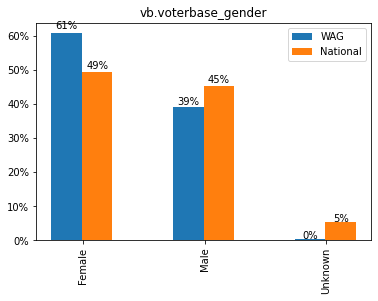

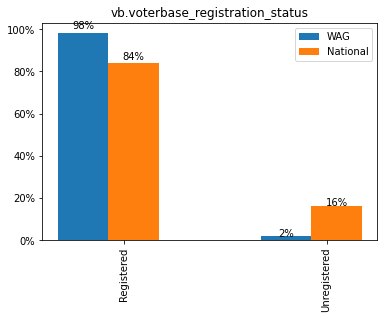

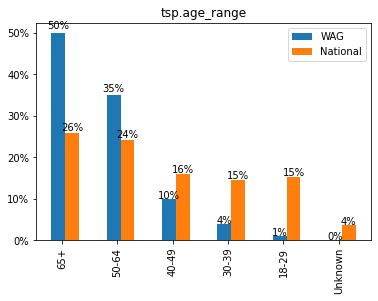

In [22]:
plot_fields(["vb.voterbase_gender", "vb.voterbase_registration_status", 'tsp.age_range'])

## Closing the PDF file
When you're done saving the graphs into the PDF, close it.

In [23]:
pdf.close()